In [1]:
# Imports
import torch
import torch.nn as nn
import torch.nn.functional as F
from einops import rearrange #pip install einops
from typing import List
import random
import math
import json
from torchvision import datasets, transforms
from torch.utils.data import DataLoader 
from timm.utils import ModelEmaV3 #pip install timm 
from tqdm import tqdm #pip install tqdm
import matplotlib.pyplot as plt #pip install matplotlib
import torch.optim as optim
import numpy as np
from PIL import Image


In [2]:
from image_processing import prep_dataset, thresholding

In [3]:
img_paths, _ = prep_dataset.load_img_paths("/nfsscratch/Users/ifang/heds-data/inpainting/AugmentedData_bf")

In [4]:
IMG_SIZE = 128

In [5]:
class SinusoidalEmbeddings(nn.Module):
    def __init__(self, time_steps: int, embed_dim: int):
        super().__init__()
        position = torch.arange(time_steps).unsqueeze(1).float()
        div_term = torch.exp(torch.arange(0, embed_dim, 2).float() * (-math.log(10000.0) / embed_dim))
        embeddings = torch.zeros(time_steps, embed_dim)
        embeddings[:, 0::2] = torch.sin(position * div_term)
        embeddings[:, 1::2] = torch.cos(position * div_term)
        # Register embeddings as a buffer so it moves with the model
        self.register_buffer('embeddings', embeddings)

    def forward(self, t):
        embeds = self.embeddings[t]
        return embeds  # Shape: [batch_size, embed_dim]

In [6]:
class ResBlock(nn.Module):
    def __init__(self, C: int, num_groups: int, dropout_prob: float, embed_dim: int):
        super().__init__()
        self.relu = nn.ReLU(inplace=True)
        self.gnorm1 = nn.GroupNorm(num_groups=num_groups, num_channels=C)
        self.gnorm2 = nn.GroupNorm(num_groups=num_groups, num_channels=C)
        self.conv1 = nn.Conv2d(C, C, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(C, C, kernel_size=3, padding=1)
        self.dropout = nn.Dropout(p=dropout_prob, inplace=True)
        # Linear layer to project embeddings to match the number of channels in x
        self.embed_fc = nn.Linear(embed_dim, C)

    def forward(self, x, embeddings):
        # embeddings: [batch_size, embed_dim, 1, 1]
        # Squeeze spatial dimensions
        emb = embeddings.squeeze(-1).squeeze(-1)  # Shape: [batch_size, embed_dim]
        # Project embeddings to match channels in x
        emb = self.embed_fc(emb)  # Shape: [batch_size, C]
        # Reshape for broadcasting
        emb = emb.unsqueeze(-1).unsqueeze(-1)  # Shape: [batch_size, C, 1, 1]
        x = x + emb  # Broadcasting addition
        r = self.conv1(self.relu(self.gnorm1(x)))
        r = self.dropout(r)
        r = self.conv2(self.relu(self.gnorm2(r)))
        return r + x

In [7]:
class Attention(nn.Module):
    def __init__(self, C: int, num_heads: int, dropout_prob: float):
        super().__init__()
        self.proj1 = nn.Linear(C, C * 3)
        self.proj2 = nn.Linear(C, C)
        self.num_heads = num_heads
        self.dropout_prob = dropout_prob

    def forward(self, x):
        b, c, h, w = x.size()
        x = rearrange(x, 'b c h w -> b (h w) c')  # [batch_size, sequence_length, channels]
        x = self.proj1(x)
        x = rearrange(x, 'b L (C H K) -> K b H L C', K=3, H=self.num_heads)
        q, k, v = x[0], x[1], x[2]
        x = F.scaled_dot_product_attention(q, k, v, is_causal=False, dropout_p=self.dropout_prob)
        x = rearrange(x, 'b H L C -> b L (H C)')
        x = self.proj2(x)
        x = rearrange(x, 'b (h w) C -> b C h w', h=h, w=w)
        return x

In [8]:
class UnetLayer(nn.Module):
    def __init__(self, upscale: bool, attention: bool, num_groups: int, dropout_prob: float, num_heads: int, C: int, embed_dim: int):
        super().__init__()
        self.ResBlock1 = ResBlock(C=C, num_groups=num_groups, dropout_prob=dropout_prob, embed_dim=embed_dim)
        self.ResBlock2 = ResBlock(C=C, num_groups=num_groups, dropout_prob=dropout_prob, embed_dim=embed_dim)
        if upscale:
            self.conv = nn.ConvTranspose2d(C, C // 2, kernel_size=4, stride=2, padding=1)
        else:
            self.conv = nn.Conv2d(C, C * 2, kernel_size=3, stride=2, padding=1)
        if attention:
            self.attention_layer = Attention(C, num_heads=num_heads, dropout_prob=dropout_prob)

    def forward(self, x, embeddings):
        x = self.ResBlock1(x, embeddings)
        if hasattr(self, 'attention_layer'):
            x = self.attention_layer(x)
        x = self.ResBlock2(x, embeddings)
        return self.conv(x), x

In [9]:
class UNET(nn.Module):
    def __init__(self,
                 Channels: List = [64, 128, 256, 512, 512, 384],
                 Attentions: List = [False, True, False, False, False, True],
                 Upscales: List = [False, False, False, True, True, True],
                 num_groups: int = 32,
                 dropout_prob: float = 0.1,
                 num_heads: int = 8,
                 input_channels: int = 1,
                 output_channels: int = 1,
                 time_steps: int = 1000):
        super().__init__()
        self.num_layers = len(Channels)
        embed_dim = max(Channels)
        self.shallow_conv = nn.Conv2d(input_channels, Channels[0], kernel_size=3, padding=1)
        out_channels = (Channels[-1] // 2) + Channels[0]
        self.late_conv = nn.Conv2d(out_channels, out_channels // 2, kernel_size=3, padding=1)
        self.output_conv = nn.Conv2d(out_channels // 2, output_channels, kernel_size=1)
        self.relu = nn.ReLU(inplace=True)

        self.time_embeddings = SinusoidalEmbeddings(time_steps=time_steps, embed_dim=embed_dim)
        self.binder_fc = nn.Sequential(
            nn.Linear(1, embed_dim),
            nn.ReLU()
        )
        
        self.combine_fc = nn.Sequential(
            nn.Linear(embed_dim * 2, embed_dim),
            nn.ReLU()
        )

        for i in range(self.num_layers):
            layer = UnetLayer(
                upscale=Upscales[i],
                attention=Attentions[i],
                num_groups=num_groups,
                dropout_prob=dropout_prob,
                C=Channels[i],
                num_heads=num_heads,
                embed_dim=embed_dim  # Pass embed_dim here
            )
            setattr(self, f'Layer{i+1}', layer)

    def forward(self, x, binder_fraction, t):
        x = self.shallow_conv(x)
        residuals = []

        device = x.device
        time_embed = self.time_embeddings(t)  # Shape: [batch_size, embed_dim]
        binder_fraction = binder_fraction.to(device)
        binder_embed = self.binder_fc(binder_fraction)  # Shape: [batch_size, embed_dim]

        combined_embed = torch.cat([time_embed, binder_embed], dim=-1)
        combined_embed = self.combine_fc(combined_embed).unsqueeze(-1).unsqueeze(-1)  # Shape: [batch_size, embed_dim, 1, 1]

        for i in range(self.num_layers // 2):
            layer = getattr(self, f'Layer{i+1}')
            x, r = layer(x, combined_embed)
            residuals.append(r)
        for i in range(self.num_layers // 2, self.num_layers):
            layer = getattr(self, f'Layer{i+1}')
            x_new, _ = layer(x, combined_embed)
            x = torch.cat((x_new, residuals[self.num_layers - i - 1]), dim=1)

        x = self.late_conv(self.relu(x))
        x = self.output_conv(self.relu(x))
        return x

In [10]:
class DDPM_Scheduler(nn.Module):
    def __init__(self, num_time_steps: int=1000):
        super().__init__()
        self.beta = torch.linspace(1e-4, 0.02, num_time_steps, requires_grad=False)
        alpha = 1 - self.beta
        self.alpha = torch.cumprod(alpha, dim=0).requires_grad_(False)

    def forward(self, t):
        return self.beta[t], self.alpha[t]

In [11]:
def set_seed(seed: int = 42):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(seed)
    random.seed(seed)

In [12]:
class PBXDataset(torch.utils.data.Dataset):
    def __init__(self, img_pathlist, transform=None):
        self.img_pathlist = img_pathlist
        self.transform = transform
        random.shuffle(img_pathlist)  
        
    def __len__(self):
        return len(self.img_pathlist)

    def __getitem__(self, idx):
        img_path = self.img_pathlist[idx]
        image = Image.open(img_path)
        if self.transform:
            image = self.transform(image)

        # Convert image to a NumPy array and squeeze to ensure correct shape
        np_img = image.numpy().squeeze()  # Ensure this is [1, 128, 128]
        #print(np_img)
        #epsilon = 1e-8  # Small constant to prevent divide-by-zero errors
        #np_image = ((np_img - np_img.min()) / (np_img.max() - np_img.min() + epsilon) * 255).astype(np.uint8)
        #print("np_img: ", np_img.shape, "\n", np_img)
        # Direct thresholding: pixels < 128 are black, >= 128 are white
        binary_img = (np_img <= 0).astype(np.uint8)  # White pixels (1s), black pixels (0s)
        #print("binary_img: ", binary_img)

        black_pixel_count = np.sum(binary_img == 1)
        total_pixels = np_img.size
        binder_fraction = black_pixel_count / total_pixels

        binder_fraction_tensor = torch.tensor([binder_fraction], dtype=torch.float32)
        
        return image, binder_fraction_tensor
        
def load_transformed_dataset(img_paths):
    data_transforms = [
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        transforms.Grayscale(),  
        transforms.ToTensor(),  # Scales data into [0, 1]
        transforms.Lambda(lambda t: (t * 2) - 1)  # Scale between [-1, 1]
    ]
    data_transform = transforms.Compose(data_transforms)

    train_dataset = PBXDataset(
        img_paths,
        transform=data_transform,
    )

    return train_dataset

train_dataset = load_transformed_dataset(img_paths)


In [13]:
def show_images_with_binder_fraction(dataset, num_samples=20, cols=4):
    fig = plt.figure(figsize=(7, 13))
    for i, (img, binder_fraction) in enumerate(dataset):
        if i == num_samples:
            break
        plt.subplot(int(num_samples / cols) + 1, cols, i + 1)
        fig.subplots_adjust(hspace=0.025, wspace=0.025) 
        plt.imshow(img[0], cmap='gray', vmin=-1, vmax=1)
        plt.title(f"Binder: {binder_fraction.item():.2f}")
        plt.axis('off')

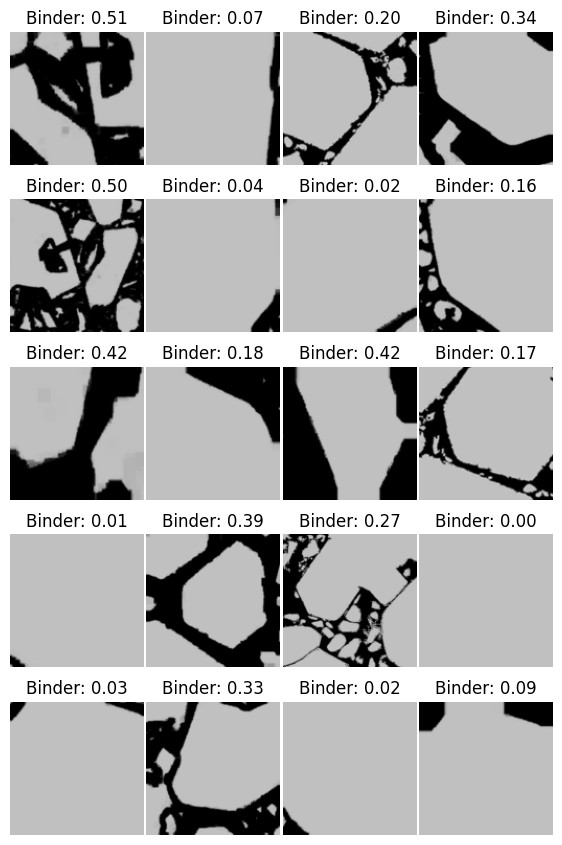

In [14]:
show_images_with_binder_fraction(train_dataset)

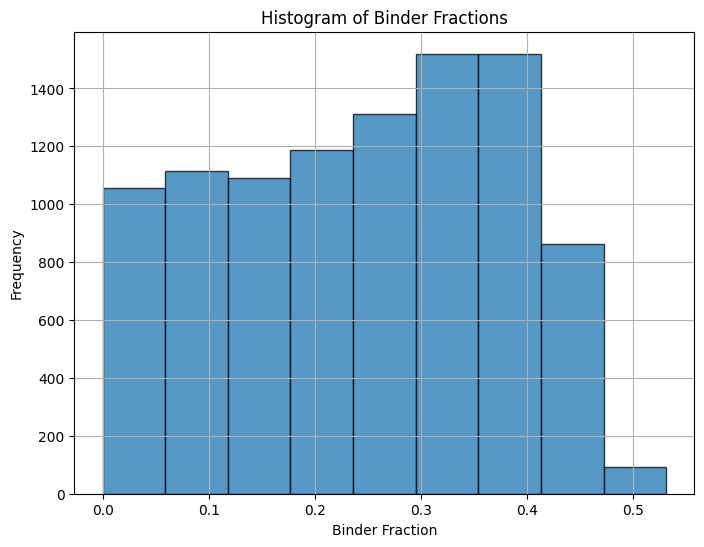

In [15]:
def plot_binder_fraction_histogram(dataset, num_bins=9):
    binder_fractions = []

    for i, (img, binder_fraction) in enumerate(dataset):
        binder_fractions.append(binder_fraction.item())

    plt.figure(figsize=(8, 6))
    plt.hist(binder_fractions, bins=num_bins, edgecolor='black', alpha=0.75)
    plt.title('Histogram of Binder Fractions')
    plt.xlabel('Binder Fraction')
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.show()

# Use this function to plot the histogram of binder fractions
plot_binder_fraction_histogram(train_dataset)

In [16]:
def train(batch_size: int=16,
          num_time_steps: int=1000,
          num_epochs: int=15,
          seed: int=-1,
          ema_decay: float=0.9999,  
          lr=2e-5,
          checkpoint_path: str=None):
    set_seed(random.randint(0, 2**32-1)) if seed == -1 else set_seed(seed)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True, num_workers=4)

    scheduler = DDPM_Scheduler(num_time_steps=num_time_steps)
    model = UNET().cuda()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    ema = ModelEmaV3(model, decay=ema_decay)
    if checkpoint_path is not None:
        checkpoint = torch.load(checkpoint_path)
        model.load_state_dict(checkpoint['weights'])
        ema.load_state_dict(checkpoint['ema'])
        optimizer.load_state_dict(checkpoint['optimizer'])
    criterion = nn.MSELoss(reduction='mean')

    for i in range(num_epochs):
        total_loss = 0
        for bidx, (x, bf) in enumerate(tqdm(train_loader, desc=f"Epoch {i+1}/{num_epochs}")):
            x = x.cuda()
            #x = F.pad(x, (2,2,2,2))
            t = torch.randint(0,num_time_steps,(batch_size,))
            e = torch.randn_like(x, requires_grad=False)
            a = scheduler.alpha[t].view(batch_size,1,1,1).cuda()
            x = (torch.sqrt(a)*x) + (torch.sqrt(1-a)*e)
            output = model(x, bf, t)
            optimizer.zero_grad()
            loss = criterion(output, e)
            total_loss += loss.item()
            loss.backward()
            optimizer.step()
            ema.update(model)
        print(f'Epoch {i+1} | Loss {total_loss / (len(train_dataset)/batch_size):.5f}')

    checkpoint = {
        'weights': model.state_dict(),
        'optimizer': optimizer.state_dict(),
        'ema': ema.state_dict()
    }
    torch.save(checkpoint, 'checkpoints/pbx_conditional_v7.1')


def plot_losses_from_json(json_file: str):
    with open(json_file, 'r') as f:
        losses = json.load(f)
    
    # Plot the losses
    plt.figure(figsize=(8, 6))
    plt.plot(losses, marker='o')
    plt.title('Training Loss per Epoch')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid(True)
    plt.show()

In [17]:
def display_reverse(images: List):
    fig, axes = plt.subplots(1, 10, figsize=(10,1))
    for i, ax in enumerate(axes.flat):
        x = images[i].squeeze(0)
        x = rearrange(x, 'c h w -> h w c')
        x = x.numpy()
        ax.imshow(x, cmap='gray')
        ax.axis('off')
    plt.show()

def calculate_binder_fraction(image):
    np_img = image.numpy().squeeze()
    binary_img = (np_img <= 0).astype(np.uint8)  
    black_pixel_count = np.sum(binary_img == 1)
    total_pixels = np_img.size
    binder_fraction = black_pixel_count / total_pixels
    return binder_fraction

def inference(checkpoint_path: str = None,
              num_time_steps: int = 1000,
              ema_decay: float = 0.9999):
    checkpoint = torch.load(checkpoint_path)
    model = UNET().cuda(
    model.load_state_dict(checkpoint['weights'])
    ema = ModelEmaV3(model, decay=ema_decay)
    ema.load_state_dict(checkpoint['ema'])
    scheduler = DDPM_Scheduler(num_time_steps=num_time_steps)
    times = [0, 15, 50, 100, 200, 300, 400, 550, 700, 999]
    final_images = []  
    reverse_images = []  
    requested_binder_fractions = [] 
    actual_binder_fractions = []

    with torch.no_grad():
        model = ema.module.eval()
        for i in range(6):
            requested_binder_fraction = random.uniform(0.1, 0.6)
            requested_binder_fractions.append(requested_binder_fraction)

            binder_fraction_tensor = torch.tensor([requested_binder_fraction], dtype=torch.float32).cuda()

            z = torch.randn(1, 1, IMG_SIZE, IMG_SIZE)
            reverse_steps = []  
            for t in reversed(range(1, num_time_steps)):
                t = [t]
                temp = (scheduler.beta[t] / ((torch.sqrt(1 - scheduler.alpha[t])) * (torch.sqrt(1 - scheduler.beta[t]))))
                z = (1 / (torch.sqrt(1 - scheduler.beta[t]))) * z - (temp * model(z.cuda(), binder_fraction_tensor.unsqueeze(-1), t).cpu())
                if t[0] in times:
                    reverse_steps.append(z.clone()) 
                e = torch.randn(1, 1, IMG_SIZE, IMG_SIZE)
                z = z + (e * torch.sqrt(scheduler.beta[t]))
            temp = scheduler.beta[0] / ((torch.sqrt(1 - scheduler.alpha[0])) * (torch.sqrt(1 - scheduler.beta[0])))
            x = (1 / (torch.sqrt(1 - scheduler.beta[0]))) * z - (temp * model(z.cuda(), binder_fraction_tensor.unsqueeze(-1), [0]).cpu())

            final_images.append(x.clone())  
            reverse_steps.append(x)
            reverse_images.append(reverse_steps)

            actual_binder_fraction = calculate_binder_fraction(x.cpu())
            actual_binder_fractions.append(actual_binder_fraction)

    fig, axes = plt.subplots(2, 3, figsize=(6, 4))
    for i, ax in enumerate(axes.flat):
        x = rearrange(final_images[i].squeeze(0), 'c h w -> h w c').detach().numpy()
        ax.imshow(x, cmap='gray')
        requested = requested_binder_fractions[i]
        actual = actual_binder_fractions[i]
        ax.set_title(f"Requested: {requested:.2f}, Actual: {actual:.2f}", fontsize=8)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

    for reverse_steps in reverse_images:
        display_reverse(reverse_steps)

In [18]:
train(checkpoint_path=None, lr=2e-5, num_epochs=100)

Epoch 1/100: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 609/609 [02:21<00:00,  4.29it/s]


Epoch 1 | Loss 0.12195


Epoch 2/100: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 609/609 [02:22<00:00,  4.27it/s]


Epoch 2 | Loss 0.03043


Epoch 3/100: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 609/609 [02:22<00:00,  4.27it/s]


Epoch 3 | Loss 0.02383


Epoch 4/100: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 609/609 [02:22<00:00,  4.26it/s]


Epoch 4 | Loss 0.02084


Epoch 5/100: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 609/609 [02:23<00:00,  4.26it/s]


Epoch 5 | Loss 0.01922


Epoch 6/100: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 609/609 [02:23<00:00,  4.24it/s]


Epoch 6 | Loss 0.01734


Epoch 7/100: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 609/609 [02:23<00:00,  4.25it/s]


Epoch 7 | Loss 0.01681


Epoch 8/100: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 609/609 [02:23<00:00,  4.26it/s]


Epoch 8 | Loss 0.01529


Epoch 9/100: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 609/609 [02:23<00:00,  4.25it/s]


Epoch 9 | Loss 0.01526


Epoch 10/100: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 609/609 [02:23<00:00,  4.25it/s]


Epoch 10 | Loss 0.01423


Epoch 11/100: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 609/609 [02:22<00:00,  4.26it/s]


Epoch 11 | Loss 0.01348


Epoch 12/100: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 609/609 [02:23<00:00,  4.24it/s]


Epoch 12 | Loss 0.01269


Epoch 13/100: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 609/609 [02:23<00:00,  4.25it/s]


Epoch 13 | Loss 0.01169


Epoch 14/100: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 609/609 [02:23<00:00,  4.25it/s]


Epoch 14 | Loss 0.01146


Epoch 15/100: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 609/609 [02:23<00:00,  4.25it/s]


Epoch 15 | Loss 0.01110


Epoch 16/100: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 609/609 [02:23<00:00,  4.25it/s]


Epoch 16 | Loss 0.01071


Epoch 17/100: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 609/609 [02:23<00:00,  4.25it/s]


Epoch 17 | Loss 0.01046


Epoch 18/100: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 609/609 [02:23<00:00,  4.26it/s]


Epoch 18 | Loss 0.01047


Epoch 19/100: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 609/609 [02:22<00:00,  4.26it/s]


Epoch 19 | Loss 0.01025


Epoch 20/100: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 609/609 [02:23<00:00,  4.25it/s]


Epoch 20 | Loss 0.00994


Epoch 21/100: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 609/609 [02:23<00:00,  4.24it/s]


Epoch 21 | Loss 0.00950


Epoch 22/100: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 609/609 [02:23<00:00,  4.25it/s]


Epoch 22 | Loss 0.00967


Epoch 23/100: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 609/609 [02:23<00:00,  4.24it/s]


Epoch 23 | Loss 0.00941


Epoch 24/100: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 609/609 [02:23<00:00,  4.25it/s]


Epoch 24 | Loss 0.00974


Epoch 25/100: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 609/609 [02:23<00:00,  4.25it/s]


Epoch 25 | Loss 0.00909


Epoch 26/100: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 609/609 [02:22<00:00,  4.26it/s]


Epoch 26 | Loss 0.00925


Epoch 27/100: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 609/609 [02:22<00:00,  4.26it/s]


Epoch 27 | Loss 0.00901


Epoch 28/100: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 609/609 [02:22<00:00,  4.27it/s]


Epoch 28 | Loss 0.00929


Epoch 29/100: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 609/609 [02:22<00:00,  4.26it/s]


Epoch 29 | Loss 0.00891


Epoch 30/100: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 609/609 [02:22<00:00,  4.27it/s]


Epoch 30 | Loss 0.00925


Epoch 31/100: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 609/609 [02:22<00:00,  4.26it/s]


Epoch 31 | Loss 0.00854


Epoch 32/100: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 609/609 [02:22<00:00,  4.27it/s]


Epoch 32 | Loss 0.00854


Epoch 33/100: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 609/609 [02:22<00:00,  4.26it/s]


Epoch 33 | Loss 0.00854


Epoch 34/100: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 609/609 [02:23<00:00,  4.26it/s]


Epoch 34 | Loss 0.00832


Epoch 35/100: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 609/609 [02:22<00:00,  4.26it/s]


Epoch 35 | Loss 0.00851


Epoch 36/100: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 609/609 [02:22<00:00,  4.27it/s]


Epoch 36 | Loss 0.00826


Epoch 37/100: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 609/609 [02:22<00:00,  4.27it/s]


Epoch 37 | Loss 0.00811


Epoch 38/100: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 609/609 [02:22<00:00,  4.27it/s]


Epoch 38 | Loss 0.00829


Epoch 39/100: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 609/609 [02:22<00:00,  4.27it/s]


Epoch 39 | Loss 0.00775


Epoch 40/100: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 609/609 [02:22<00:00,  4.26it/s]


Epoch 40 | Loss 0.00858


Epoch 41/100: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 609/609 [02:22<00:00,  4.27it/s]


Epoch 41 | Loss 0.00775


Epoch 42/100: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 609/609 [02:22<00:00,  4.27it/s]


Epoch 42 | Loss 0.00822


Epoch 43/100: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 609/609 [02:22<00:00,  4.27it/s]


Epoch 43 | Loss 0.00768


Epoch 44/100: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 609/609 [02:22<00:00,  4.27it/s]


Epoch 44 | Loss 0.00786


Epoch 45/100: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 609/609 [02:22<00:00,  4.27it/s]


Epoch 45 | Loss 0.00796


Epoch 46/100: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 609/609 [02:22<00:00,  4.27it/s]


Epoch 46 | Loss 0.00758


Epoch 47/100: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 609/609 [02:22<00:00,  4.27it/s]


Epoch 47 | Loss 0.00728


Epoch 48/100: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 609/609 [02:22<00:00,  4.27it/s]


Epoch 48 | Loss 0.00744


Epoch 49/100: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 609/609 [02:22<00:00,  4.27it/s]


Epoch 49 | Loss 0.00745


Epoch 50/100: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 609/609 [02:22<00:00,  4.27it/s]


Epoch 50 | Loss 0.00724


Epoch 51/100: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 609/609 [02:22<00:00,  4.27it/s]


Epoch 51 | Loss 0.00734


Epoch 52/100: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 609/609 [02:22<00:00,  4.27it/s]


Epoch 52 | Loss 0.00714


Epoch 53/100: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 609/609 [02:22<00:00,  4.27it/s]


Epoch 53 | Loss 0.00733


Epoch 54/100: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 609/609 [02:22<00:00,  4.27it/s]


Epoch 54 | Loss 0.00692


Epoch 55/100: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 609/609 [02:22<00:00,  4.27it/s]


Epoch 55 | Loss 0.00735


Epoch 56/100: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 609/609 [02:22<00:00,  4.27it/s]


Epoch 56 | Loss 0.00723


Epoch 57/100: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 609/609 [02:22<00:00,  4.27it/s]


Epoch 57 | Loss 0.00679


Epoch 58/100: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 609/609 [02:22<00:00,  4.27it/s]


Epoch 58 | Loss 0.00717


Epoch 59/100: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 609/609 [02:22<00:00,  4.27it/s]


Epoch 59 | Loss 0.00688


Epoch 60/100: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 609/609 [02:22<00:00,  4.27it/s]


Epoch 60 | Loss 0.00697


Epoch 61/100: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 609/609 [02:22<00:00,  4.27it/s]


Epoch 61 | Loss 0.00680


Epoch 62/100: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 609/609 [02:22<00:00,  4.27it/s]


Epoch 62 | Loss 0.00667


Epoch 63/100: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 609/609 [02:22<00:00,  4.27it/s]


Epoch 63 | Loss 0.00650


Epoch 64/100: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 609/609 [02:22<00:00,  4.27it/s]


Epoch 64 | Loss 0.00647


Epoch 65/100: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 609/609 [02:22<00:00,  4.27it/s]


Epoch 65 | Loss 0.00678


Epoch 66/100: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 609/609 [02:22<00:00,  4.27it/s]


Epoch 66 | Loss 0.00657


Epoch 67/100: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 609/609 [02:22<00:00,  4.27it/s]


Epoch 67 | Loss 0.00635


Epoch 68/100: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 609/609 [02:22<00:00,  4.27it/s]


Epoch 68 | Loss 0.00604


Epoch 69/100: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 609/609 [02:22<00:00,  4.27it/s]


Epoch 69 | Loss 0.00672


Epoch 70/100: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 609/609 [02:22<00:00,  4.26it/s]


Epoch 70 | Loss 0.00632


Epoch 71/100: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 609/609 [02:22<00:00,  4.26it/s]


Epoch 71 | Loss 0.00642


Epoch 72/100: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 609/609 [02:22<00:00,  4.26it/s]


Epoch 72 | Loss 0.00651


Epoch 73/100: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 609/609 [02:22<00:00,  4.26it/s]


Epoch 73 | Loss 0.00624


Epoch 74/100: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 609/609 [02:23<00:00,  4.25it/s]


Epoch 74 | Loss 0.00604


Epoch 75/100: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 609/609 [02:22<00:00,  4.26it/s]


Epoch 75 | Loss 0.00608


Epoch 76/100: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 609/609 [02:23<00:00,  4.25it/s]


Epoch 76 | Loss 0.00620


Epoch 77/100: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 609/609 [02:23<00:00,  4.25it/s]


Epoch 77 | Loss 0.00603


Epoch 78/100: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 609/609 [02:23<00:00,  4.24it/s]


Epoch 78 | Loss 0.00600


Epoch 79/100: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 609/609 [02:23<00:00,  4.26it/s]


Epoch 79 | Loss 0.00586


Epoch 80/100: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 609/609 [02:23<00:00,  4.26it/s]


Epoch 80 | Loss 0.00591


Epoch 81/100: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 609/609 [02:23<00:00,  4.25it/s]


Epoch 81 | Loss 0.00631


Epoch 82/100: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 609/609 [02:23<00:00,  4.25it/s]


Epoch 82 | Loss 0.00607


Epoch 83/100: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 609/609 [02:23<00:00,  4.25it/s]


Epoch 83 | Loss 0.00563


Epoch 84/100: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 609/609 [02:23<00:00,  4.25it/s]


Epoch 84 | Loss 0.00573


Epoch 85/100: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 609/609 [02:23<00:00,  4.25it/s]


Epoch 85 | Loss 0.00572


Epoch 86/100: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 609/609 [02:23<00:00,  4.25it/s]


Epoch 86 | Loss 0.00584


Epoch 87/100: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 609/609 [02:23<00:00,  4.25it/s]


Epoch 87 | Loss 0.00560


Epoch 88/100: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 609/609 [02:23<00:00,  4.25it/s]


Epoch 88 | Loss 0.00569


Epoch 89/100: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 609/609 [02:23<00:00,  4.25it/s]


Epoch 89 | Loss 0.00575


Epoch 90/100: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 609/609 [02:23<00:00,  4.26it/s]


Epoch 90 | Loss 0.00605


Epoch 91/100: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 609/609 [02:23<00:00,  4.25it/s]


Epoch 91 | Loss 0.00546


Epoch 92/100: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 609/609 [02:23<00:00,  4.25it/s]


Epoch 92 | Loss 0.00551


Epoch 93/100: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 609/609 [02:23<00:00,  4.26it/s]


Epoch 93 | Loss 0.00560


Epoch 94/100: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 609/609 [02:23<00:00,  4.25it/s]


Epoch 94 | Loss 0.00585


Epoch 95/100: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 609/609 [02:23<00:00,  4.25it/s]


Epoch 95 | Loss 0.00577


Epoch 96/100: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 609/609 [02:23<00:00,  4.25it/s]


Epoch 96 | Loss 0.00549


Epoch 97/100: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 609/609 [02:23<00:00,  4.25it/s]


Epoch 97 | Loss 0.00570


Epoch 98/100: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 609/609 [02:23<00:00,  4.25it/s]


Epoch 98 | Loss 0.00530


Epoch 99/100: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 609/609 [02:23<00:00,  4.25it/s]


Epoch 99 | Loss 0.00539


Epoch 100/100: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 609/609 [02:23<00:00,  4.25it/s]


Epoch 100 | Loss 0.00540


/tmp/ipykernel_2054713/3387954634.py:23: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path)


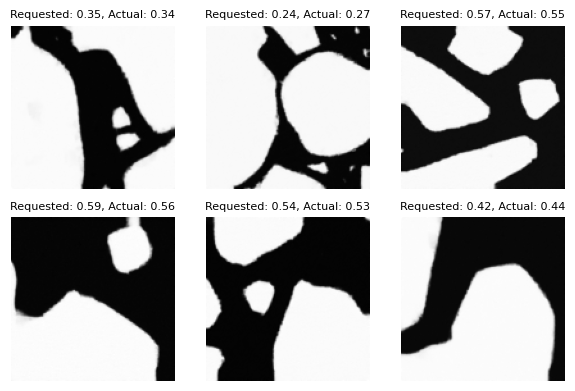

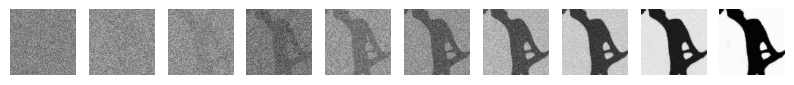

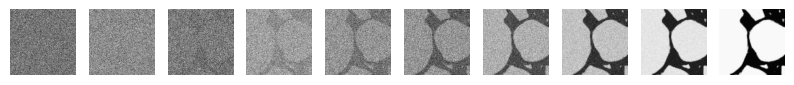

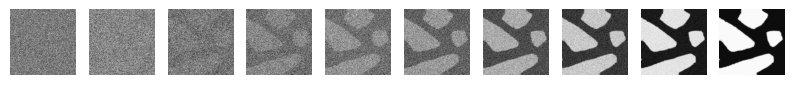

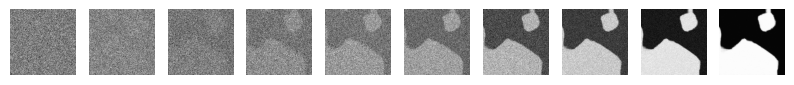

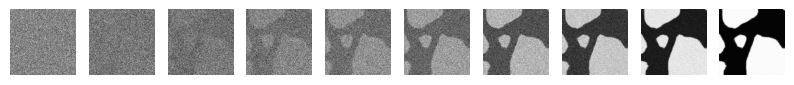

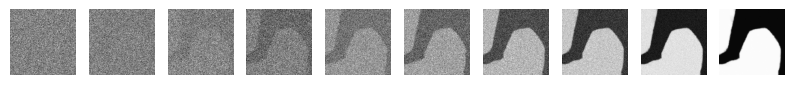

In [19]:
inference('checkpoints/pbx_conditional_v7.1')


In [20]:
#plot_losses_from_json('binary_circle_unconditional_v3.0_losses.json')

In [21]:
def inference_one(binder_fraction: float, checkpoint_path: str = None,
                                        num_time_steps: int = 1000,
                                        ema_decay: float = 0.9999):
    checkpoint = torch.load(checkpoint_path)
    model = UNET().cuda()
    model.load_state_dict(checkpoint['weights'])
    ema = ModelEmaV3(model, decay=ema_decay)
    ema.load_state_dict(checkpoint['ema'])
    scheduler = DDPM_Scheduler(num_time_steps=num_time_steps)
    times = [0, 15, 50, 100, 200, 300, 400, 550, 700, 999]
    final_images = [] 
    reverse_images = []  
    actual_binder_fractions = []  

    with torch.no_grad():
        model = ema.module.eval()
        requested_binder_fraction = binder_fraction

        binder_fraction_tensor = torch.tensor([requested_binder_fraction], dtype=torch.float32).cuda()

        z = torch.randn(1, 1, IMG_SIZE, IMG_SIZE)
        reverse_steps = []  
        for t in reversed(range(1, num_time_steps)):
            t = [t]
            temp = (scheduler.beta[t] / ((torch.sqrt(1 - scheduler.alpha[t])) * (torch.sqrt(1 - scheduler.beta[t]))))
            z = (1 / (torch.sqrt(1 - scheduler.beta[t]))) * z - (temp * model(z.cuda(), binder_fraction_tensor.unsqueeze(-1), t).cpu())
            if t[0] in times:
                reverse_steps.append(z.clone()) 
            e = torch.randn(1, 1, IMG_SIZE, IMG_SIZE)
            z = z + (e * torch.sqrt(scheduler.beta[t]))
        temp = scheduler.beta[0] / ((torch.sqrt(1 - scheduler.alpha[0])) * (torch.sqrt(1 - scheduler.beta[0])))
        x = (1 / (torch.sqrt(1 - scheduler.beta[0]))) * z - (temp * model(z.cuda(), binder_fraction_tensor.unsqueeze(-1), [0]).cpu())

        final_images.append(x.clone()) 
        reverse_steps.append(x)
        reverse_images.append(reverse_steps)

        actual_binder_fraction = calculate_binder_fraction(x.cpu())
        actual_binder_fractions.append(actual_binder_fraction)

    x = rearrange(final_images[0].squeeze(0), 'c h w -> h w c').detach().numpy()
    plt.figure(figsize=(1, 1))
    plt.imshow(x, cmap='gray')
    actual = actual_binder_fractions[0]
    plt.title(f"Requested: {binder_fraction:.2f}, Actual: {actual:.2f}", fontsize=8)
    plt.axis('off')
    plt.tight_layout()
    plt.show()

    for reverse_steps in reverse_images:
        display_reverse(reverse_steps)

/tmp/ipykernel_2054713/3312446630.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path)


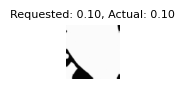

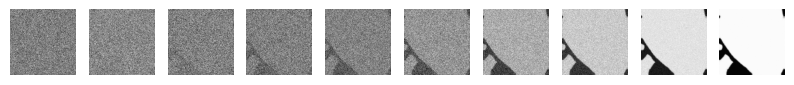

In [22]:
inference_one(0.1, 'checkpoints/pbx_conditional_v7.1')
